# 1.ICESAT-2有效波高显示

## 变量说明
### 前缀
hy_     HY-2B卫星
cy_     CryoSat-2卫星
什么都没有的是ICESAT-2卫星

### 后缀
_west    代表西半球

In [1]:
import pyproj
from  pyproj  import  CRS
from pyproj import Proj
import h5py
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm, colors
import glob
from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset



In [2]:
# 设置空间分辨率
resolution = 10000

# 将WGS 84坐标（4326）转化为等距圆柱投影（4088）
crs = CRS.from_epsg(4326)
crs = CRS.from_string("epsg:4326")
crs = CRS.from_proj4("+proj=latlon")
crs = CRS.from_user_input(4326)
crs2 = CRS(proj="aeqd")

transformer = pyproj.Transformer.from_crs(crs,crs2)
transformer_back = pyproj.Transformer.from_crs(crs2,crs)

In [3]:
# 获取数组的长和宽
def get_nlat_nlon_npaeqd(resolution):
    nlat, nlon =40000000/ resolution,40000000/ resolution
    nlat = np.int(nlat)
    nlon = np.int(nlon)
    return nlat, nlon
    
# 获取用来存放数据的grid数组，及其对应的grid_num数组（用来存放一个格子中有多少重合点）
def get_swh_grid(nlat, nlon):
    swh_grid = np.full(shape=(nlon,nlat), fill_value=np.nan)
    swh_grid_num = np.zeros((nlon,nlat))
    return swh_grid, swh_grid_num

# 填充每个点的数值，将有重复数据的点标记到swh_grid_num中,最后求平均
def  coincident_point_mean(value_array, grid_array, grid_num_array, projlats, projlons):
    for i in range(len(value_array)):
        x = int((projlons[i] )/resolution)
        y = int(projlats[i]/resolution)
        if grid_num_array[x][y] == 0:
            grid_array[x][y] = value_array[i]
            grid_num_array[x][y] += 1
        else:
            grid_array[x][y] += value_array[i]
            grid_num_array[x][y] += 1
    grid_array = grid_array / grid_num_array
    return grid_array

In [4]:
"读取单个h5文件并可视化,最后图像为一条轨道上的数据"

dir_path = '.\H2B_nc_data\ICESAT2_ATL12_20200711'
ncfiles = glob.glob(dir_path + '\*.h5')
is_lon_array = np.array([])
is_lat_array = np.array([])
is_value_array = np.array([])
for ncfile in ncfiles:
    with h5py.File(ncfile, 'r') as f:
        lats = f['gt2l']['ssh_segments']['latitude'][:]
        lons = f['gt2l']['ssh_segments']['longitude'][:]
        value = f['gt2l']['ssh_segments']['heights']['swh'][:]
    is_lon_array = np.append(is_lon_array, lons)
    is_lat_array = np.append(is_lat_array, lats)
    is_value_array = np.append(is_value_array, value)


In [5]:
is_lon_array_west = is_lon_array - 180
is_lat_array_west = is_lat_array

In [6]:
is_projlats,is_projlons = transformer.transform(is_lat_array,is_lon_array)
is_projlats_west,is_projlons_west = transformer.transform(is_lat_array_west,is_lon_array_west)

In [7]:
# 获取东西半球的nlat，nlon，is_grid_west,is_grid_num_west
nlat, nlon =get_nlat_nlon_npaeqd(resolution)
is_grid, is_grid_num = get_swh_grid(nlat, nlon)

nlat_west, nlon_west =get_nlat_nlon_npaeqd(resolution)
is_grid_west, is_grid_num_west = get_swh_grid(nlat, nlon)

# 交叉点平均化
is_grid = coincident_point_mean(is_value_array, is_grid, is_grid_num, is_projlats,is_projlons)
is_grid_west = coincident_point_mean(is_value_array, is_grid_west, is_grid_num_west, is_projlats_west, is_projlons_west)

In [8]:
# 东半球校准y坐标,将xx,yy转换回坐标形式
x = np.arange(nlat)
y = np.arange(nlon)
xx , yy = np.meshgrid(x * resolution, y * resolution)
y_map, x_map = transformer_back.transform(xx , yy)

# 西半球校准y坐标,将xx,yy转换回坐标形式
x_west = np.arange(nlat_west)
y_west = np.arange(nlon_west) 
xx_west , yy_west = np.meshgrid(x_west * resolution, y_west * resolution)
y_map_west, x_map_west = transformer_back.transform(xx_west , yy_west)
x_map_west = x_map_west-180

<ipython-input-9-5dbeba5cc0bb>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  h = m.pcolor(xi ,yi, data=is_grid, cmap=plt.cm.jet,vmin=0, vmax=5)
<ipython-input-9-5dbeba5cc0bb>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  h2 = m.pcolor(xi_west ,yi_west, data=is_grid_west, cmap=plt.cm.jet,vmin=0, vmax=5)


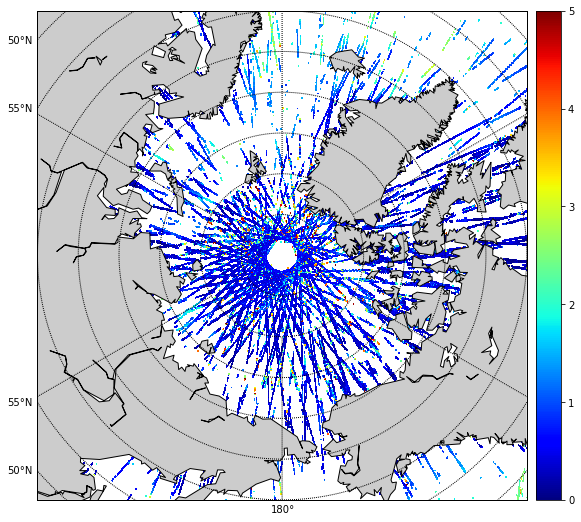

In [9]:
plt.figure(1,figsize=(16, 9))
# m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=0, urcrnrlon=360, resolution='c')
m = Basemap(projection='npaeqd', boundinglat=60, lon_0=180, resolution='c')
m_west = Basemap(projection='npaeqd', boundinglat=60, lon_0=180, resolution='c')
xi, yi = m(x_map, y_map)
xi_west ,yi_west = m(x_map_west, y_map_west)

h = m.pcolor(xi ,yi, data=is_grid, cmap=plt.cm.jet,vmin=0, vmax=5)
h2 = m.pcolor(xi_west ,yi_west, data=is_grid_west, cmap=plt.cm.jet,vmin=0, vmax=5)
m.colorbar(location='right')
# plt.cm.ScalarMappable.set_clim(h, vmin=0, vmax=10)

m.drawcoastlines()
m.fillcontinents()
m.drawmapboundary()
m.drawparallels(np.arange(-90., 120., 5.), labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])

plt.show(1)

# 2.HY-2B有效波高显示

In [13]:
month = '08'
hy_dir_path = r'/mnt/raid2/users/hanlu/remote_sensing/data/HY2B/' + month
hyfiles = glob.glob(hy_dir_path + '/*.nc')
hy_lon_array = np.array([])
hy_lat_array = np.array([])
hy_value_array = np.array([])
hy_swhc_mask_array = np.array([])
for hyfile in hyfiles:
    fh = Dataset(hyfile, mode='r')
    lons = fh.variables['lon'][:]
    lats = fh.variables['lat'][:]
    swhc = fh.variables['swh_c'][:]
    swhc_mask = swhc.mask
    hy_lon_array = np.append(hy_lon_array, lons)
    hy_lat_array = np.append(hy_lat_array, lats)
    hy_value_array = np.append(hy_value_array, swhc)
    hy_swhc_mask_array = np.append(hy_swhc_mask_array, swhc_mask)
    fh.close()
hy_value_array_masked = np.ma.array(hy_value_array, mask=hy_swhc_mask_array)


In [21]:
hy_value_array_masked

masked_array(data=[--, --, 1.008, ..., --, --, --],
             mask=[ True,  True, False, ...,  True,  True,  True],
       fill_value=1e+20)

In [25]:
index = []
for i in range(len(hy_value_array_masked)):
    if hy_lat_array[i] < 66:
        index.append(i)

hy_lat_array = np.delete(hy_lat_array, index)
hy_lon_array = np.delete(hy_lon_array, index)
hy_value_array = np.delete(hy_value_array, index)
hy_swhc_mask_array = np.delete(hy_swhc_mask_array, index)
hy_value_array_masked = np.ma.array(hy_value_array, mask=hy_swhc_mask_array)

In [26]:
hy_lon_array_west = hy_lon_array - 180
hy_lat_array_west = hy_lat_array

hy_projlats,hy_projlons = transformer.transform(hy_lat_array,hy_lon_array)
hy_projlats_west,hy_projlons_west = transformer.transform(hy_lat_array_west,hy_lon_array_west)

In [28]:
# 获取东西半球的nlat，nlon，hy_grid_west,hy_grid_num_west
hy_nlat, hy_nlon =get_nlat_nlon_npaeqd(resolution)
hy_grid, hy_grid_num = get_swh_grid(hy_nlat, hy_nlon)

hy_nlat_west, hy_nlon_west =get_nlat_nlon_npaeqd(resolution)
hy_grid_west, hy_grid_num_west = get_swh_grid(hy_nlat, hy_nlon)

# 交叉点平均化
hy_grid = coincident_point_mean(hy_value_array_masked, hy_grid, hy_grid_num, hy_projlats,hy_projlons)
hy_grid_west = coincident_point_mean(hy_value_array_masked, hy_grid_west, hy_grid_num_west, hy_projlats_west, hy_projlons_west)

<ipython-input-3-b084ab6424b3>:20: UserWarning: Warning: converting a masked element to nan.
  grid_array[x][y] = value_array[i]
<ipython-input-3-b084ab6424b3>:23: UserWarning: Warning: converting a masked element to nan.
  grid_array[x][y] += value_array[i]


In [30]:
# 校准y坐标
hy_x = np.arange(hy_nlat)
hy_y = np.arange(hy_nlon)
hy_xx , hy_yy = np.meshgrid(hy_x * resolution, hy_y * resolution)

# 将xx,yy转换回坐标形式
hy_y_map, hy_x_map = transformer_back.transform(hy_xx , hy_yy)

# 校准y坐标
hy_x_west = np.arange(hy_nlat_west)
hy_y_west = np.arange(hy_nlon_west) 
hy_xx_west , hy_yy_west = np.meshgrid(hy_x_west * resolution, hy_y_west * resolution)

# 将xx,yy转换回坐标形式
hy_y_map_west, hy_x_map_west = transformer_back.transform(hy_xx_west , hy_yy_west)
hy_x_map_west = hy_x_map_west-180

<ipython-input-42-8f9ed7ee0f40>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  h = hy_m.pcolormesh(hy_xi ,hy_yi, data=hy_grid, cmap=plt.cm.jet,vmin=0, vmax=5)
<ipython-input-42-8f9ed7ee0f40>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  h2 = hy_m.pcolormesh(hy_xi_west ,hy_yi_west, data=hy_grid_west, cmap=plt.cm.jet,vmin=0, vmax=5)


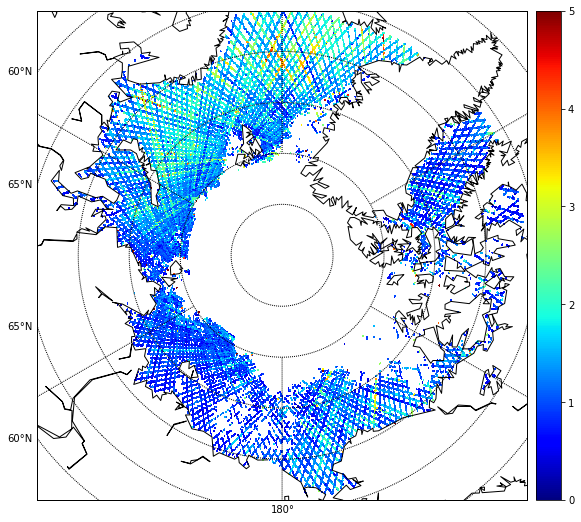

In [42]:
plt.figure(1,figsize=(16, 9))
# hy_m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=0, urcrnrlon=360, resolution='c')
hy_m = Basemap(projection='npaeqd', boundinglat=66, lon_0=180, resolution='c')

hy_xi, hy_yi = hy_m(hy_x_map, hy_y_map)
hy_xi_west ,hy_yi_west = hy_m(hy_x_map_west, hy_y_map_west)

# Draw the scatterplot
h = hy_m.pcolormesh(hy_xi ,hy_yi, data=hy_grid, cmap=plt.cm.jet,vmin=0, vmax=5)
h2 = hy_m.pcolormesh(hy_xi_west ,hy_yi_west, data=hy_grid_west, cmap=plt.cm.jet,vmin=0, vmax=5)
hy_m.colorbar(location='right')

hy_m.drawcoastlines()
# hy_m.fillcontinents()
hy_m.drawmapboundary()
hy_m.drawparallels(np.arange(-90., 120., 5.), labels=[1, 0, 0, 0])
hy_m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])

plt.show(1)
plt.close()

# 3.CryoSat-2有效波高显示

CryoSat-2的有效波高只提供了Ku波段的，HY-2B的有效波高提供了C波段和Ku波段

In [5]:
cy_dir_path = r"/mnt/raid2/users/hanlu/remote_sensing/data/CRYOSAT2/08"
cyfiles = glob.glob(cy_dir_path + '/*.nc')
cy_lon_array = np.array([])
cy_lat_array = np.array([])
cy_swh_array = np.array([])
cy_swh_mask_array = np.array([])
for cyfile in cyfiles:
    with Dataset(cyfile, mode='r') as fh:
        lons = fh.variables['lon_01'][:]
        lats = fh.variables['lat_01'][:]
        swh = fh.variables['swh_ocean_01_ku'][:]
        swh_mask = swh.mask
        if np.array(swh_mask,dtype = bool).shape == ():
            swh_mask = np.full((len(swh), ), False)
        cy_lon_array = np.append(cy_lon_array, lons)
        cy_lat_array = np.append(cy_lat_array, lats)
        cy_swh_array = np.append(cy_swh_array, swh)
        cy_swh_mask_array = np.append(cy_swh_mask_array, swh_mask)
        
cy_swh_array_masked = np.ma.array(cy_swh_array, mask=cy_swh_mask_array)


In [6]:
cy_lower_index = []
for i in range(len(cy_swh_array_masked)):
    if cy_lat_array[i] <66:
        cy_lower_index.append(i)

cy_lat_array = np.delete(cy_lat_array, cy_lower_index)
cy_lon_array = np.delete(cy_lon_array, cy_lower_index)
cy_swh_array = np.delete(cy_swh_array, cy_lower_index)
cy_swh_mask_array = np.delete(cy_swh_mask_array, cy_lower_index)
cy_swh_array_masked = np.ma.array(cy_swh_array, mask=cy_swh_mask_array)

In [10]:
cy_lon_array.max()

179.9913576

In [12]:
cy_lon_array_west = cy_lon_array - 180
cy_lat_array_west = cy_lat_array

cy_projlats,cy_projlons = transformer.transform(cy_lat_array,cy_lon_array)
cy_projlats_west,cy_projlons_west = transformer.transform(cy_lat_array_west,cy_lon_array_west)

In [13]:
# 获取东西半球的nlat，nlon，cy_grid_west,cy_grid_num_west
cy_nlat, cy_nlon =get_nlat_nlon_npaeqd(resolution)
cy_grid, cy_grid_num = get_swh_grid(cy_nlat, cy_nlon)

cy_nlat_west, cy_nlon_west =get_nlat_nlon_npaeqd(resolution)
cy_grid_west, cy_grid_num_west = get_swh_grid(cy_nlat, cy_nlon)

# 交叉点平均化
cy_grid = coincident_point_mean(cy_swh_array_masked, cy_grid, cy_grid_num, cy_projlats,cy_projlons)
cy_grid_west = coincident_point_mean(cy_swh_array_masked, cy_grid_west, cy_grid_num_west, cy_projlats_west, cy_projlons_west)

<ipython-input-3-b084ab6424b3>:20: UserWarning: Warning: converting a masked element to nan.
  grid_array[x][y] = value_array[i]
<ipython-input-3-b084ab6424b3>:23: UserWarning: Warning: converting a masked element to nan.
  grid_array[x][y] += value_array[i]


In [14]:
# 校准y坐标
cy_x = np.arange(cy_nlat)
cy_y = np.arange(cy_nlon)
cy_xx , cy_yy = np.meshgrid(cy_x * resolution, cy_y * resolution)

# 将xx,yy转换回坐标形式
cy_y_map, cy_x_map = transformer_back.transform(cy_xx , cy_yy)

# 校准y坐标
cy_x_west = np.arange(cy_nlat_west)
cy_y_west = np.arange(cy_nlon_west) 
cy_xx_west , cy_yy_west = np.meshgrid(cy_x_west * resolution, cy_y_west * resolution)

# 将xx,yy转换回坐标形式
cy_y_map_west, cy_x_map_west = transformer_back.transform(cy_xx_west , cy_yy_west)
cy_x_map_west = cy_x_map_west-180


<ipython-input-15-9ca8369c2b3c>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  h = cy_m.pcolor(cy_xi ,cy_yi, data=cy_grid, cmap=plt.cm.jet,vmin=0, vmax=5)
<ipython-input-15-9ca8369c2b3c>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  h2 = cy_m.pcolor(cy_xi_west ,cy_yi_west, data=cy_grid_west, cmap=plt.cm.jet,vmin=0, vmax=5)


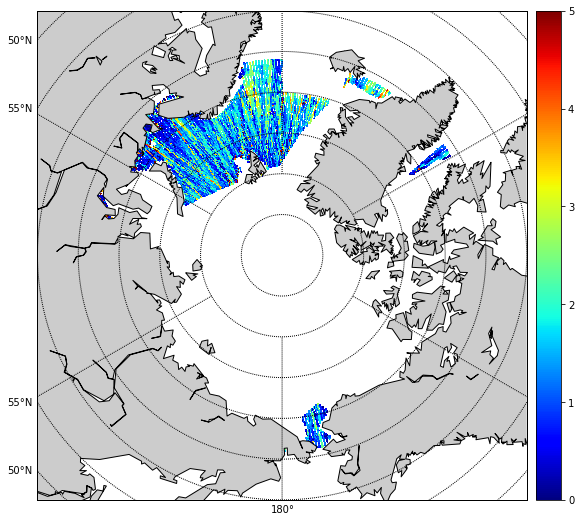

In [15]:
plt.figure(1,figsize=(16, 9))
# cy_m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=0, urcrnrlon=360, resolution='c')
cy_m = Basemap(projection='npaeqd', boundinglat=60, lon_0=180, resolution='c')

cy_xi, cy_yi = cy_m(cy_x_map, cy_y_map)
cy_xi_west ,cy_yi_west = cy_m(cy_x_map_west, cy_y_map_west)

# Draw the scatterplot
h = cy_m.pcolor(cy_xi ,cy_yi, data=cy_grid, cmap=plt.cm.jet,vmin=0, vmax=5)
h2 = cy_m.pcolor(cy_xi_west ,cy_yi_west, data=cy_grid_west, cmap=plt.cm.jet,vmin=0, vmax=5)
cy_m.colorbar(location='right')


cy_m.drawcoastlines()
cy_m.fillcontinents()
cy_m.drawmapboundary()
cy_m.drawparallels(np.arange(-90., 120., 5.), labels=[1, 0, 0, 0])
cy_m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])

plt.show(1)
plt.close()

<ipython-input-34-f3575a50ed42>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  h = hy_m.pcolor(hy_xi ,hy_yi, data=hy_grid, cmap=plt.cm.jet,vmin=0, vmax=5)
<ipython-input-34-f3575a50ed42>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  h2 = hy_m.pcolor(hy_xi_west ,hy_yi_west, data=hy_grid_west, cmap=plt.cm.jet,vmin=0, vmax=5)
<ipython-input-34-f3575a50ed42>:32: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is dep

Text(0.5, 1.0, 'CryoSat-2 Significant Wave Height')

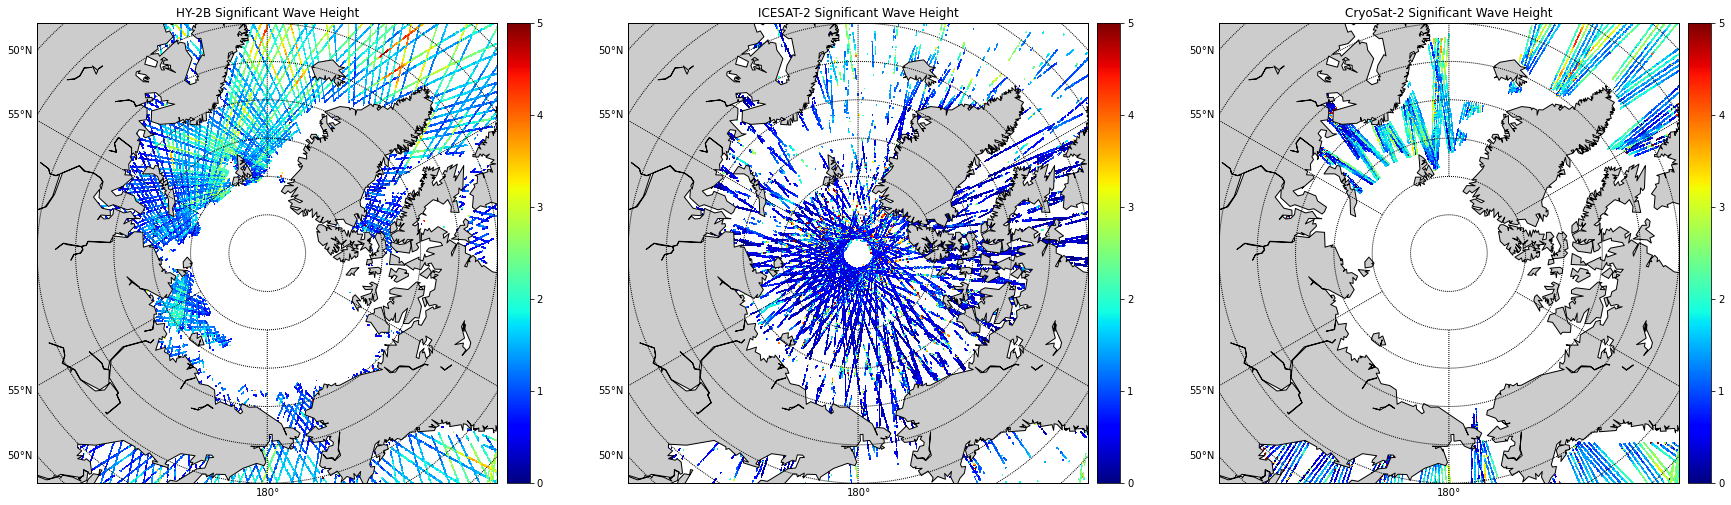

In [34]:
fig = plt.figure(figsize=(30,20) )    # 生成新的画布fig

ax1 = fig.add_subplot(131) 
hy_m = Basemap(projection='npaeqd', boundinglat=60, lon_0=180, resolution='c')

hy_xi, hy_yi = hy_m(hy_x_map, hy_y_map)
hy_xi_west ,hy_yi_west = hy_m(hy_x_map_west, hy_y_map_west)

# Draw the scatterplot
h = hy_m.pcolor(hy_xi ,hy_yi, data=hy_grid, cmap=plt.cm.jet,vmin=0, vmax=5)
h2 = hy_m.pcolor(hy_xi_west ,hy_yi_west, data=hy_grid_west, cmap=plt.cm.jet,vmin=0, vmax=5)
hy_m.colorbar(location='right')

hy_m.drawcoastlines()
hy_m.fillcontinents()
hy_m.drawmapboundary()
hy_m.drawparallels(np.arange(-90., 120., 5.), labels=[1, 0, 0, 0])
hy_m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])


plt.title("HY-2B Significant Wave Height")
  

ax2 = fig.add_subplot(132)
# m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=0, urcrnrlon=360, resolution='c')
m = Basemap(projection='npaeqd', boundinglat=60, lon_0=180, resolution='c')
m_west = Basemap(projection='npaeqd', boundinglat=60, lon_0=180, resolution='c')
xi, yi = m(x_map, y_map)
xi_west ,yi_west = m(x_map_west, y_map_west)

# Draw the scatterplot
h = m.pcolor(xi ,yi, data=is_grid, cmap=plt.cm.jet,vmin=0, vmax=5)
h2 = m.pcolor(xi_west ,yi_west, data=is_grid_west, cmap=plt.cm.jet,vmin=0, vmax=5)
m.colorbar(location='right')
# plt.cm.ScalarMappable.set_clim(h, vmin=0, vmax=10)

m.drawcoastlines()
m.fillcontinents()
m.drawmapboundary()
m.drawparallels(np.arange(-90., 120., 5.), labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])
plt.title("ICESAT-2 Significant Wave Height")

ax3 = fig.add_subplot(133)

cy_m = Basemap(projection='npaeqd', boundinglat=60, lon_0=180, resolution='c')

cy_xi, cy_yi = cy_m(cy_x_map, cy_y_map)
cy_xi_west ,cy_yi_west = cy_m(cy_x_map_west, cy_y_map_west)

h = cy_m.pcolor(cy_xi ,cy_yi, data=cy_grid, cmap=plt.cm.jet,vmin=0, vmax=5)
h2 = cy_m.pcolor(cy_xi_west ,cy_yi_west, data=cy_grid_west, cmap=plt.cm.jet,vmin=0, vmax=5)
cy_m.colorbar(location='right')


cy_m.drawcoastlines()
cy_m.fillcontinents()
cy_m.drawmapboundary()
cy_m.drawparallels(np.arange(-90., 120., 5.), labels=[1, 0, 0, 0])
cy_m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])

plt.title("CryoSat-2 Significant Wave Height")



# 4.重合点数值比较

In [35]:
# 将两个grid数组相减，还有数据的部分为交叉点
hy_cy_grid = np.abs(hy_grid - cy_grid )
hy_cy_grid_west = np.abs(hy_grid_west - cy_grid_west) 

# hy_cy_diff_grid，hy_cy_diff_grid_west存放重合点在grid数组中的坐标 
hy_cy_diff_grid = np.argwhere(np.isnan(hy_cy_grid)!= True)
hy_cy_diff_grid_west = np.argwhere(np.isnan(hy_cy_grid_west)!= True)

In [41]:
'''count = 0
for i in range(len(hy_cy_diff_grid)):
    print(hy_grid[hy_cy_diff_grid[i][0], hy_cy_diff_grid[i][1]],cy_grid[hy_cy_diff_grid[i][0], hy_cy_diff_grid[i][1]],round(hy_cy_grid[hy_cy_diff_grid[i][0], hy_cy_diff_grid[i][1]], 8))
    count+=1
for j in range(len(hy_cy_diff_grid_west)):
    print(hy_grid_west[hy_cy_diff_grid_west[j][0], hy_cy_diff_grid_west[j][1]], cy_grid_west[hy_cy_diff_grid_west[j][0], hy_cy_diff_grid_west[j][1]], round(hy_cy_grid_west[hy_cy_diff_grid_west[j][0], hy_cy_diff_grid_west[j][1]], 8))
    count+=1
    
print(count)'''

'count = 0\nfor i in range(len(hy_cy_diff_grid)):\n    print(hy_grid[hy_cy_diff_grid[i][0], hy_cy_diff_grid[i][1]],cy_grid[hy_cy_diff_grid[i][0], hy_cy_diff_grid[i][1]],round(hy_cy_grid[hy_cy_diff_grid[i][0], hy_cy_diff_grid[i][1]], 8))\n    count+=1\nfor j in range(len(hy_cy_diff_grid_west)):\n    print(hy_grid_west[hy_cy_diff_grid_west[j][0], hy_cy_diff_grid_west[j][1]], cy_grid_west[hy_cy_diff_grid_west[j][0], hy_cy_diff_grid_west[j][1]], round(hy_cy_grid_west[hy_cy_diff_grid_west[j][0], hy_cy_diff_grid_west[j][1]], 8))\n    count+=1\n    \nprint(count)'

<ipython-input-43-8b2f3fd1b697>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  h = cy_m.pcolor(cy_xi ,cy_yi, data=hy_cy_grid, cmap=plt.cm.jet,vmin=0, vmax=2)
<ipython-input-43-8b2f3fd1b697>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  h2 = cy_m.pcolor(cy_xi_west ,cy_yi_west, data=hy_cy_grid_west, cmap=plt.cm.jet,vmin=0, vmax=2)


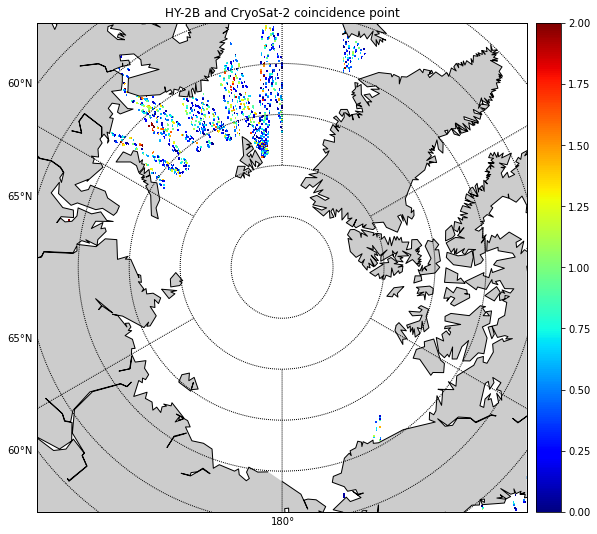

In [43]:
plt.figure(1,figsize=(16, 9))
# cy_m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=0, urcrnrlon=360, resolution='c')
cy_m = Basemap(projection='npaeqd', boundinglat=66, lon_0=180, resolution='c')

cy_xi, cy_yi = cy_m(cy_x_map, cy_y_map)

# Draw the scatterplot
h = cy_m.pcolor(cy_xi ,cy_yi, data=hy_cy_grid, cmap=plt.cm.jet,vmin=0, vmax=2)
h2 = cy_m.pcolor(cy_xi_west ,cy_yi_west, data=hy_cy_grid_west, cmap=plt.cm.jet,vmin=0, vmax=2)
cy_m.colorbar(location='right')
cy_m.drawcoastlines()
cy_m.fillcontinents()
cy_m.drawmapboundary()
cy_m.drawparallels(np.arange(-90., 120., 5.), labels=[1, 0, 0, 0])
cy_m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])
plt.title("HY-2B and CryoSat-2 coincidence point")
plt.show(1)
plt.close()

In [38]:
# 将两个grid数组相减，还有数据的部分为交叉点
hy_is_grid = np.abs(hy_grid - is_grid )
hy_is_grid_west = np.abs(hy_grid_west - is_grid_west) 

# hy_is_diff_grid，hy_is_diff_grid_west存放重合点在grid数组中的坐标 
hy_is_diff_grid = np.argwhere(np.isnan(hy_is_grid)!= True)
hy_is_diff_grid_west = np.argwhere(np.isnan(hy_is_grid_west)!= True)

In [44]:
'''count = 0 
for i in range(len(hy_is_diff_grid)):
    print(hy_grid[hy_is_diff_grid[i][0], hy_is_diff_grid[i][1]],is_grid[hy_is_diff_grid[i][0], hy_is_diff_grid[i][1]],round(hy_is_grid[hy_is_diff_grid[i][0], hy_is_diff_grid[i][1]], 8))
    count += 1
for j in range(len(hy_is_diff_grid_west)):
    print(hy_grid_west[hy_is_diff_grid_west[j][0], hy_is_diff_grid_west[j][1]], is_grid_west[hy_is_diff_grid_west[j][0], hy_is_diff_grid_west[j][1]], round(hy_is_grid_west[hy_is_diff_grid_west[j][0], hy_is_diff_grid_west[j][1]], 8))
    count += 1
print(count)'''

'count = 0 \nfor i in range(len(hy_is_diff_grid)):\n    print(hy_grid[hy_is_diff_grid[i][0], hy_is_diff_grid[i][1]],is_grid[hy_is_diff_grid[i][0], hy_is_diff_grid[i][1]],round(hy_is_grid[hy_is_diff_grid[i][0], hy_is_diff_grid[i][1]], 8))\n    count += 1\nfor j in range(len(hy_is_diff_grid_west)):\n    print(hy_grid_west[hy_is_diff_grid_west[j][0], hy_is_diff_grid_west[j][1]], is_grid_west[hy_is_diff_grid_west[j][0], hy_is_diff_grid_west[j][1]], round(hy_is_grid_west[hy_is_diff_grid_west[j][0], hy_is_diff_grid_west[j][1]], 8))\n    count += 1\nprint(count)'

<ipython-input-45-46f4f3406e0f>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  h2 = cy_m.pcolor(cy_xi ,cy_yi, data=hy_is_grid, cmap=plt.cm.jet,vmin=0, vmax=2)
<ipython-input-45-46f4f3406e0f>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  h2 = cy_m.pcolor(cy_xi_west ,cy_yi_west, data=hy_is_grid_west, cmap=plt.cm.jet,vmin=0, vmax=2)


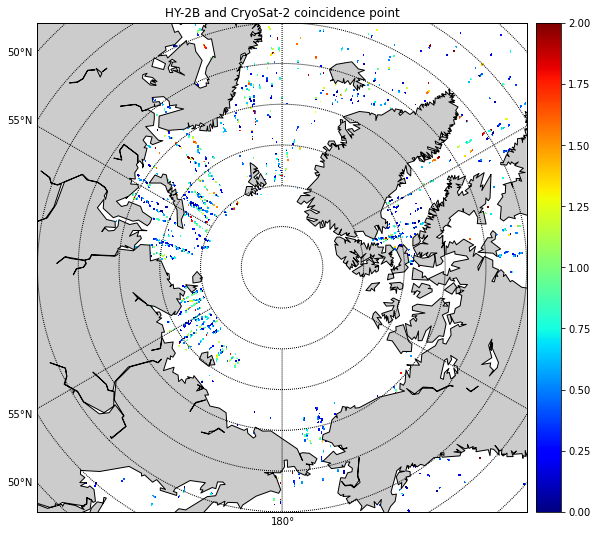

In [45]:
plt.figure(1,figsize=(16, 9))
# cy_m = Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=0, urcrnrlon=360, resolution='c')
cy_m = Basemap(projection='npaeqd', boundinglat=60, lon_0=180, resolution='c')

cy_xi, cy_yi = cy_m(cy_x_map, cy_y_map)
cy_xi_west ,cy_yi_west = cy_m(cy_x_map_west, cy_y_map_west)

# Draw the scatterplot
h2 = cy_m.pcolor(cy_xi ,cy_yi, data=hy_is_grid, cmap=plt.cm.jet,vmin=0, vmax=2)
h2 = cy_m.pcolor(cy_xi_west ,cy_yi_west, data=hy_is_grid_west, cmap=plt.cm.jet,vmin=0, vmax=2)
cy_m.colorbar(location='right')
cy_m.drawcoastlines()
cy_m.fillcontinents()
cy_m.drawmapboundary()
cy_m.drawparallels(np.arange(-90., 120., 5.), labels=[1, 0, 0, 0])
cy_m.drawmeridians(np.arange(-180., 180., 60.), labels=[0, 0, 0, 1])
plt.title("HY-2B and ICESat-2 coincidence point")
plt.show(1)
plt.close()